In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from src.config import DCNConfig
from src.squad import SquadDataset
from src.model import CoattentionModel
from src.glove import GloVeEmbeddings


config = DCNConfig()

glove = GloVeEmbeddings(embedding_dim=config.glove_dim)
glove.load_glove_embeddings(config.glove_path)

train_dataset = SquadDataset(glove.word_to_idx, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=True)

eval_dataset = SquadDataset(glove.word_to_idx, split="validation")
eval_dataloader = DataLoader(eval_dataset, batch_size=config.batch_size, num_workers=config.num_workers, shuffle=False)

model = CoattentionModel(config.hidden_dim, config.maxout_pool_size, glove.get_embedding_matrix(), config.max_dec_steps, config.dropout_ratio)
use_cuda = True if torch.cuda.is_available() else False
if use_cuda:
    model = model.cuda()

opt = torch.optim.Adam(model.parameters(), lr=config.lr)

INFO:src.glove:Loading GloVe embeddings from glove_embeddings/glove.840B.300d.txt
INFO:src.glove:Processed 0 lines
INFO:src.glove:Processed 100000 lines
INFO:src.glove:Processed 200000 lines
INFO:src.glove:Processed 300000 lines
INFO:src.glove:Processed 400000 lines
INFO:src.glove:Processed 500000 lines
INFO:src.glove:Processed 600000 lines
INFO:src.glove:Processed 700000 lines
INFO:src.glove:Processed 800000 lines
INFO:src.glove:Processed 900000 lines
INFO:src.glove:Processed 1000000 lines
INFO:src.glove:Processed 1100000 lines
INFO:src.glove:Processed 1200000 lines
INFO:src.glove:Processed 1300000 lines
INFO:src.glove:Processed 1400000 lines
INFO:src.glove:Processed 1500000 lines
INFO:src.glove:Processed 1600000 lines
INFO:src.glove:Processed 1700000 lines


In [2]:
print(f"Embedding matrix shape: {glove.get_embedding_matrix().shape}") # Should be (vocab_size, embedding_dim)
print(f"Vocabulary size: {len(glove.word_to_idx)}")
print(f"Index of 'the': {glove.word_to_idx.get('the', 'Not found')}")
print(f"Index of 'McDonald': {glove.word_to_idx.get('McDonald', 'Not found')}")
print(f"Index of '<PAD>': {glove.word_to_idx.get('<PAD>', 'Not found')}")
print(f"Index of '<UNK>': {glove.word_to_idx.get('<UNK>', 'Not found')}")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(eval_dataset)}")
print("")

sample_idx = 33
print(f"\nSample #{sample_idx}")
print(f"Context: {eval_dataset.context_data[sample_idx][:190]}...")
print(f"Question: {eval_dataset.question_data[sample_idx]}")
print(f"Answer span: {eval_dataset.answer_span_data[sample_idx]}")
# answer_text = eval_dataset.context_data[sample_idx]
# print(f"Answer: '{answer_text}'")
print("")

# print("Embedded view:")
# context_ids, context_len, question_ids, question_len, answer_span = eval_dataset[sample_idx]

# print(f"Context IDs: {context_ids}")
# print(f"Context length: {context_len}")
# print(f"Question IDs: {question_ids}")
# print(f"Question length: {question_len}")
# print(f"Answer span: {answer_span}")


Embedding matrix shape: (2196020, 300)
Vocabulary size: 2196020
Index of 'the': 6
Index of 'McDonald': 9172
Index of '<PAD>': 0
Index of '<UNK>': 1
Total training samples: 87580
Total validation samples: 10570


Sample #33
Context: The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Cha...
Question: What team did the Panthers defeat?
Answer span: (25, 26)



## Train

In [3]:
# Training tracking
best_eval_loss = float('inf')
train_losses = []
eval_losses = []

os.makedirs(config.model_save_path, exist_ok=True)
device = torch.device('cuda' if use_cuda else 'cpu')
print("Training started!")
for epoch in trange(config.num_epochs, desc="Epoch"):
    epoch_train_loss = 0
    num_batches = 0

    for iteration, batch in enumerate(tqdm(train_dataloader)):
        
        # Skip batches if enabled
        if config.skip_frequency > 1 and iteration % config.skip_frequency != 0:
            continue
        
        # Unpack the batch
        context, context_lens, question, question_lens, answer_spans = batch

        context = context.to(device)
        context_lens = context_lens.view(-1).to(device)
        question = question.to(device)
        question_lens = question_lens.view(-1).to(device)
        answer_spans = answer_spans.to(device)
        
        # Reset gradients
        opt.zero_grad()
        
        # === Forward pass ===
        loss, _, _ = model(context, context_lens, question, question_lens, answer_spans)
        
        # === Backpropagation ===
        loss.backward()
        opt.step()

        total_loss = loss.item()
        epoch_train_loss += total_loss
        num_batches += 1

        if num_batches % config.print_frequency == 0:
            print(f"Epoch: {epoch+1} Iteration: {iteration+1} loss: {total_loss}")
            
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)
    
    # Validation at the end of each epoch
    if (epoch + 1) % config.eval_frequency == 0:  # Note: moved to epoch level
        print("Running validation...")
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in eval_dataloader:
                context, context_lens, question, question_lens, answer_spans = val_batch
                
                # Move validation data to device
                context = context.to(device)
                context_lens = context_lens.view(-1).to(device)
                question = question.to(device)
                question_lens = question_lens.view(-1).to(device)
                answer_spans = answer_spans.to(device)
                
                loss, _, _ = model(context, context_lens, question, question_lens, answer_spans)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(eval_dataloader)
        eval_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_eval_loss:
            best_eval_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(config.model_save_path, 'best_model.pt'))
            print("New best model saved!")
        
        model.train()  # Switch back to training mode

    # === Save model checkpoint ===
    print("Saving model checkpoint...")
    torch.save(model.state_dict(), os.path.join(config.model_save_path, f'model_epoch_{epoch+1}.pt'))

print("Training completed!!!")

Training started!


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 Iteration: 100 loss: 2.405519723892212


Epoch: 1 Iteration: 200 loss: 2.3755202293395996


Epoch: 1 Iteration: 300 loss: 2.3324012756347656


Epoch: 1 Iteration: 400 loss: 2.448439121246338


Epoch: 1 Iteration: 500 loss: 2.3886947631835938


Epoch: 1 Iteration: 600 loss: 2.3722524642944336


Epoch: 1 Iteration: 700 loss: 2.3908119201660156


Epoch:   0%|          | 0/2 [06:11<?, ?it/s]


KeyboardInterrupt: 

## Plots

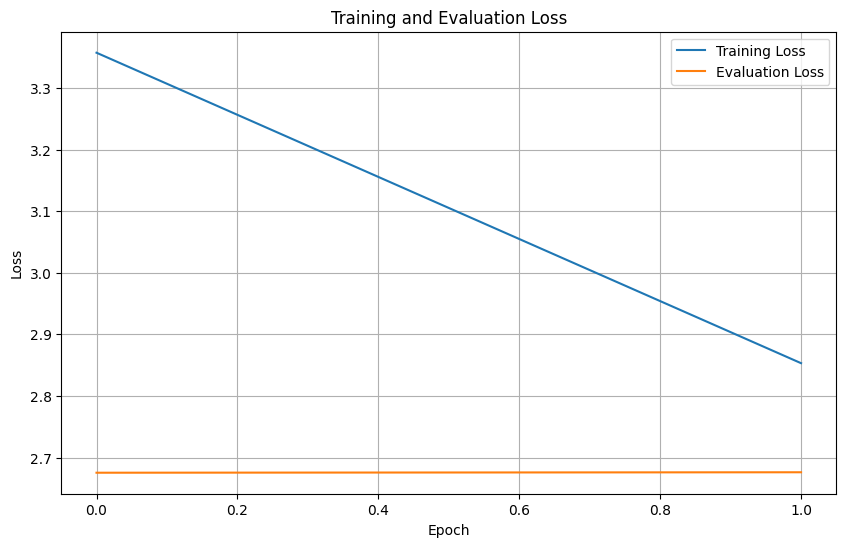

In [4]:
# Optional: Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
# plt.savefig('training_curves.png')
plt.show()